In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.collections
from scipy.interpolate import interp1d
sns.set()
from results import load
from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}
experiment_phase_labels = [*experiment_phase]

#avoid Font-problem in plots for ACM/IEEE papers
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Reading the results

In [2]:
#config
experiment_name = "full"
load_raw = False
all = None
providers = None
num_repetitions = None
configs = None

if load_raw:

    providers = ["aws","azure","ibm","gcf"] 
    num_repetitions = 1
    configs = ["0,0,1", "0,0,2","0,0,0.5","60,60,1","60,60,0.5"]


    all = load(experiment_name, providers,configs,num_repetitions,True)
    all.to_csv("results/full.csv")
else :
    all = pd.read_csv("results/full.csv")#
    providers = all["Provider"].unique()
    num_repetitions = all["run"].max()
    configs = all["WL"].unique()

all.columns


Index(['Unnamed: 0', 'RId', 'WL', 'CId', 'CStart', 'ECost', 'DLat', 'ELat',
       'RFailed', 'Phase', 'RStart', 'EStart', 'EEnd', 'REnd', 'CNew', 'CPlat',
       'TLat', 'COs', 'RInput', 'Provider', 'RLat', 'BLat', 'RResult', 'run',
       'sourceFile', 'RCode', 'RSuccessed', 'HId'],
      dtype='object')

In [3]:
def plotWorkload(ax,data,label="Target Workload",interval=1000):
    data["RStart_1s"] = round(data["RStart"]/interval)
    lats = data.groupby(["RStart_1s"])['RId'].count().reset_index(name="workload")
    sns.lineplot(x="RStart_1s", y='workload', data=lats, color="gray",label=label,ax=ax)
    
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import colorsys
    h = color.lstrip('#')
    
    c = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    c = map(lambda x:min(x+10,255),c)
    c = map(lambda x:hex(x)[2:],c)
    return "#{}{}{}".format(*c)

In [4]:
#sns.set_palette(sns.color_palette("Paired"))

palette = sns.color_palette().as_hex()
style = {
    "aws":{
        "name":"AWS",
        "color":palette[8]
    },
    "ibm":{
        "name":"ICF",
        "color":palette[1]
    },
    "gcf":{
        "name":"GCF",
        "color":palette[2]
    },
    "azure":{
        "name":"MAF",
        "color":palette[4]
    },
    "CNew":{
        "New":"#0485d1",
        "Cold":"#0485d1",
        "Reused": "#fc5a50",
        "Warm": "#fc5a50"
    },
    #colors
    "Lats":{
        "Delivery Latency":"#d1ffbd",
        "Request-Response Latency":"#448ee4",
        "Execution Latency":"#25a36f",
        "Backward Response Delivery Latency":"#89a203",
        "Delivery":"#89a203",
        "Delivery Latency":"#89a203",
        "Request-Response":"#448ee4",
        "Execution":"#25a36f",
        "Backward Response Delivery":"#89a203",
        "DLat":"#89a203",
        "BLat":"#89a203",
        "RLat":"#448ee4",
        "ELat":"#25a36f"
    },
    "Phases":{
        "p0":"#74B52F",
        "p2":"#2F74B5",
        "p1":"#B52F74",
        "warmup":"#74B52F",
        "cooldown":"#2F74B5",
        "scaling":"#B52F74"
    },
    #Strings
    "Names":{
        "DLat":"Delivery Latency",
        "RLat":"Request-Response Latency",
        "ELat":"Execution Latency",
        "BLat":"Backward Response Delivery Latency",
        "p0":"warmup",
        "p1":"scaling",
        "p2":"cooldown",
        "HId":"VM",
        "CId":"Container"
    }
    
}

hmcmp = [(1,1,1,1)]+sns.color_palette("OrRd", 10)

sns.set(style="whitegrid")




In [5]:
legendShapes = []
legendNames = []
for x in ["RLat","ELat","DLat"]:
    c = style["Lats"][x]
    legendShapes.append(Line2D([0], [0], marker='s', lw=0,color=c,markerfacecolor=c, markersize=10))
    legendNames.append(x)

for x in ["New","Reused"]:
    c = style["CNew"][x]
    legendShapes.append(Line2D([0], [0], marker='s', lw=0,color=c,markerfacecolor=c, markersize=10))
    legendNames.append(x)

for x in ["p0","p1","p2"]:
    c = style["Phases"][x]
    legendShapes.append(Line2D([0], [0], marker='s', lw=0,color=c,markerfacecolor=c, markersize=10))
    legendNames.append(x)

for x in ["aws","ibm","gcf","azure"]:
    c = style[x]["color"]
    legendShapes.append(Line2D([0], [0], marker='s', lw=0,color=c,markerfacecolor=c, markersize=10))
    legendNames.append(x)

# fig,ax = plt.subplots()
# ax.set_title("Style Palette")
# ax.legend(legendShapes, legendNames,fancybox=True, shadow=True)

In [6]:
#this is important for phase based plots (leave it otherwise)
all = all[(all["Phase"] != "none")]

### DLat vs Cold Start

In [7]:
def plotLatColdWarm(ax,all,provider,workload,lat="DLat",title=None):
    if title is None:
        ax.set_title("{} {}".format(style[provider]["name"],style["Names"][lat]))
    else:
        ax.set_title(title)
    data = all[(all["Provider"] == provider) & (all["WL"] == workload)]
    #data = data[data["DLat"].notna()]
    #data = data[data["RCode"] != 429] #filters filed requests e.g. azure
    #data = data[data["Phase"].isin(["p1","p2"])]

    data = data.replace({'CNew': "New"}, {'CNew': 'Cold'})
    data = data.replace({'CNew': "Reused"}, {'CNew': 'Warm'})
    data = data.rename(columns={"CNew":"Type"})
    sns.violinplot(x='Phase', y=lat,hue="Type", data=data,  scale='count',
                   cut=0,ax=ax,  inner='quartile',split=True,bw='scott',
                   scale_hue=True,palette=style["CNew"])

    #ax.set_yscale('log')

    ax.set_xlabel("Phases")
    ax.set_ylabel(r"Latency [s]")
    #ax.set_ylim([0,20])
    #highlight phases

    #ax.set_xticklabels(["p0","p1","p2","none"])

    delta = 0.02
    delta = 0.02
    inner = None
    #code for gap between violin halves, from stackoverflow.com/questions/43357274/
    for ii, item in enumerate(ax.collections):
    # axis contains PolyCollections and PathCollections
        if isinstance(item, matplotlib.collections.PolyCollection):
        # get path
            path, = item.get_paths()
            vertices = path.vertices

        # shift x-coordinates of path
            if not inner:
                if ii % 2: # -> to right
                    vertices[:,0] += delta
                else: # -> to left
                    vertices[:,0] -= delta
            else: # inner='box' adds another type of PollyCollection
                if ii % 3 == 0:
                    vertices[:,0] -= delta
                elif ii % 3 == 1:
                    vertices[:,0] += delta
                else: # ii % 3 = 2
                    pass

In [9]:
skip = True
if not skip:
    for workload in configs:
        for provider in providers:
            for lat in ["DLat","RLat","ELat"]:    
                fig,ax = plt.subplots()
                plotLatColdWarm(ax,all,provider,workload,lat)
                ax.set_title("Cold/Warm {} for {} {}".format(style["Names"][lat],style[provider]["name"],workload))
                fig.savefig("reports/CW_{}_{}_{}.pdf".format(lat,provider,workload))
                plt.close(fig)

### Cost per Request

In [9]:
def costPerSecond(ax,all,workload,providers=["aws","azure","ibm","gcf"],title=None):
    
    data = all[(all["WL"] == workload)&(all["Provider"].isin(providers))]
    #plot
    data = data[data["RLat"].notna()]
    data = data[data["RCode"] != 429] #filters filed requests e.g. azure
    data = data[data["Phase"].isin(["p1","p2"])]
    
    data = data.replace({'Phase': "p1"}, {'Phase': style["Names"]["p1"]})
    data = data.replace({'Phase': "p2"}, {'Phase': style["Names"]["p2"]})
    
    sns.violinplot(x='Provider', y='ECost',hue="Phase", data=data,  inner='quartile',split=True,
                  palette=style["Phases"])


    # ax.set_xlim([0,300])
    ax.set_xlabel("Phases")
    ax.set_ylabel(r"Cost [$\mu$\$]")
    ax.set_ylim([0,600])
    ax.xaxis.set_ticklabels(map(lambda x:style[x.get_text()]["name"],ax.xaxis.get_ticklabels()))
    ax.grid(False)
    #title
    if title is None:
        ax.set_title("{} - Cost per Request".format(workload))
    else:
        ax.set_title(title)
    

In [11]:
provider = "gcf"
workload = ["0,0,1","0,0,2"]

data = all[(all['Provider'] == provider) & (all["WL"].isin(workload))]
data[data["RCode"]>200].groupby(["RCode"])["RId"].count()

RCode
408.0    2038
500.0       1
Name: RId, dtype: int64

In [12]:
skip = True
if not skip:
    for workload in configs:
        fig,ax = plt.subplots()
        costPerSecond(ax,all,workload,provider=["ibm","aws","gcf"])
        fig.savefig("reports/costs_{}.pdf".format(workload))
        plt.close(fig)

### VM Usage

In [10]:
heatmap_cache = {}

In [11]:

def plotHeatmap(ax,all,provider,workload,selector="HId",cutoff=0.5,xlim=[0,300],title=None,vmax=None,cmap=sns.cubehelix_palette(8),draw_first=True,legend=True,show_cba=True):
    #filter data
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data[["EStart","EEnd",selector,"RId"]].copy()
    #remove NAN
    data = data[data["EStart"].notna()]
    data = data.reset_index()
    #second buckets
    data["EStart"] = round(data["EStart"]/1000)
    data["EEnd"] = round(data["EEnd"]/1000)

    #remove lower 20%
    X = data.groupby(selector)["RId"].count().reset_index(name="c")
    X = X[X["c"] > X["c"].quantile(cutoff)]
    
    #small note, we compress the datas x-axis by to otherwiese the plot gets to wide
    
    heatmap = None
    firstStart = None
    cache_key = "{}-{}{}-{}{}".format(selector,cutoff,str(xlim),provider,workload)
    if cache_key in heatmap_cache:
        heatmap = heatmap_cache[cache_key][0]
        firstStart = heatmap_cache[cache_key][1]
    else:
        HIdEStart = {}
        X = round(data.groupby(selector)["EStart"].min()/2)
        for hid in data[selector].unique():
            if hid in X.index:
                HIdEStart[hid] = max(0,int(X.loc[hid])-1)

        HIdIndex = {}
        idx = 0
        for hid in sorted(HIdEStart.items(), key=lambda s:s[1]):
            HIdIndex[hid[0]] = idx
            idx+=1


        #create first-start marker map
        firstStart = np.zeros((len(HIdIndex),round(xlim[1]/2)))
        for hid in HIdIndex.keys():
            if hid in X.index:
                idx = min(max(0,int(X.loc[hid])-1),firstStart.shape[1]-1)
                firstStart[HIdIndex[hid],idx] = 1

        #create heatmap by counting each invocation from EStart to EEnd
        heatmap = np.zeros((len(HIdIndex),round(xlim[1]/2)))
        for i in range(1,len(data)):
            x = data.loc[i,[selector,"EStart","EEnd"]]
            if x[selector] in HIdIndex.keys():
                #lets not talk about the following hack ;)
                for j in np.arange(x["EStart"],min(xlim[1],x["EEnd"]),2,dtype=int):

                    heatmap[HIdIndex[x[selector]],j>>1] +=1
            
        heatmap_cache[cache_key] = (heatmap,firstStart)

    sns.heatmap(heatmap,ax=ax,cmap=cmap,linewidths=0,cbar=False,vmax=vmax)
    if draw_first:
        highlight=[(1,1,1,0),(0,0,1,1)]
        sns.heatmap(firstStart,ax=ax,cmap=highlight,linewidths=0,cbar=False,vmin=0,vmax=1)
    if show_cba:
        ax_divider = make_axes_locatable(ax)
        # define size and padding of axes for colorbar
        cax = ax_divider.append_axes('right', size = '2.5%', pad = '1%')
        # make colorbar for heatmap. 
        # Heatmap returns an axes obj but you need to get a mappable obj (get_children)
        colorbar(ax.get_children()[0], cax = cax, orientation = 'vertical')
        # locate colorbar ticks
        cax.xaxis.set_ticks_position('top')
    ax.set_yticklabels([""])
    ax.set_xticks(ticks=[15,45,115])
    
    xticks = list(np.arange(0,round(xlim[1]/2)+1,30,dtype=int))
    #if not(round(xlim[1]/2) in xticks):
    xticks.append(round(xlim[1]/2))
    xticks.append(30)
    xticks.append(60)
    xticks = list(set(xticks))
    
    ax.set_xticks(ticks=xticks,minor=True)
    ax.set_xticklabels(map(lambda x:style["Names"][x],["p0","p1","p2"]),rotation='horizontal')
    ax.set_xticklabels(map(lambda x:str(x*2),ax.get_xticks(minor=True)),minor=True)
    ax.tick_params(axis='x', which='major', pad=15)
    if title is None:
        ax.set_title("{} [{}] - Parallel Requests per {} per Second".format(style[provider]["name"],workload,style["Names"][selector]))
    else:
        ax.set_title(title)
    ax.set_ylabel("Parallel Executions [#]")
    ax.set_xlabel("Elapsed Time [s]")
    
    ax.axvline(30,alpha=0.6,color="black")
    ax.axvline(60,alpha=0.6,color="black")
    if draw_first and legend:
        legendShapes = [Line2D([0], [0], marker='|', lw=0,color='blue',markerfacecolor='blue', markersize=10)]
        legendNames = ["First Occurrence"]
        ax.legend(legendShapes, legendNames,fancybox=True, shadow=True,facecolor='white')

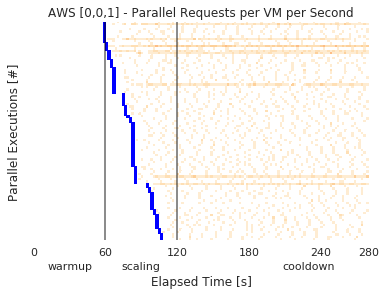

In [15]:
## preview
fig,ax = plt.subplots()
plotHeatmap(ax,all,"aws","0,0,1",selector="HId",cutoff=0.33,xlim=[0,280],cmap=hmcmp,draw_first=True,show_cba=False,legend=None,vmax=12)
ax.grid(True)

In [16]:
skip = True
if not skip:
    for workload in configs:
        for provider in providers:
            for selector in ["HId","CId"]:
                fig,ax = plt.subplots()
                h = plotHeatmap(ax,all,provider,workload,selector=selector,cutoff=0.33,xlim=[0,280],cmap=hmcmp)
                fig.savefig("reports/{}_heatmap_{}_{}.pdf".format(
                    style["Names"][selector],style[provider]["name"],workload)
                )
                plt.close(fig)

## Failed Request

In [12]:
def plotFailedRequestPerSecond(ax,all,provider,workload,plot_target=True,label=None,title=None,no_legend=False):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data.copy()
    if plot_target:
        plotWorkload(ax,data)
        
    data["RStart_1s"] = round(data["RStart"]/1000)
    #sum up cost
    data = data.groupby(["RStart_1s"])["RFailed"].sum().reset_index(name="RFailed")
    if label == None:
        label = "{}".format(style[provider]["name"])
    
    data = data[data["RFailed"] > 0]
    ax.scatter(x="RStart_1s", marker="+",y='RFailed', data=data, color="indianred",label=label,s=40)
    ax.set_xlim([0,300])
    ax.set_xlabel("time [s]")
    ax.set_ylabel(r"failed requests [#]")

    #highlight phases
    ax.axvline(60,alpha=0.7,color="black")
    ax.axvline(120,alpha=0.7,color="black")
    for i in range(0,300,20):
        ax.axvline(i,alpha=0.2,color="black")
    
    ax.grid(False)
    ax.set_xticks(ticks=[30,90,210])
    ax.set_xticks(ticks=range(0,300,20),minor=True)
    ax.set_xticklabels(map(lambda x:style["Names"][x],["p0","p1","p2"]))
    ax.set_xticklabels(range(0,300,20),minor=True)
    ax.tick_params(axis='both', which='major', pad=15)
    if title is True:
        ax.set_title("{} - Failed Request per Second".format(style[provider]["name"]))
    else:
        ax.set_title(title)
        
    if no_legend:
        ax.legend([])
    #title
    

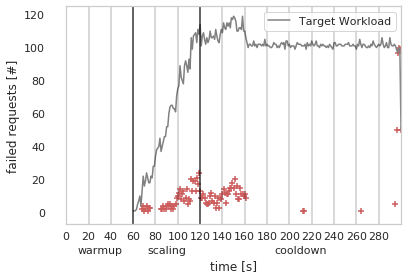

In [18]:
fig,ax = plt.subplots()
plotFailedRequestPerSecond(ax,all,"gcf","0,0,2")

In [13]:
def q(x,name):
    def _q(n):
        return np.percentile(n,x)
    _q.__name__ = name
    return _q

def prepLatData(data,provider,workload,quantile_bar=10):
    data = all[(all["Provider"] == provider) & (all["WL"] == workload)]
    data = data[["RLat","ELat","DLat","BLat","EStart","Phase"]]
    data["EStart"] = round(data["EStart"]/1000)
    data = data.groupby("EStart")[["RLat","ELat","DLat","BLat"]].agg([np.median,np.max,np.min,np.mean,q(quantile_bar,"pa"),q(100-quantile_bar,"pb")])
    
    return data


def plotLineWithErrorBar(ax,data,color="lightblue",label=None,plot_quantile=False):
    ax.plot(data["median"],label=label,color=color,zorder=2)
    if plot_quantile:
        ax.plot(data["pa"],linestyle=":",color=color,alpha=0.65,zorder=3)
        ax.plot(data["pb"],linestyle=":",color=color,alpha=0.65,zorder=3)
    ax.fill_between(data.index,data["amax"],data["amin"],alpha=0.4,color=color,zorder=1)

def plotLatOverTime(ax,all,provider,workload,lat="DLat",title=None,label=None,no_labels=False,quantile_bar=10):
    data = prepLatData(all,provider,workload,quantile_bar)[lat]
    
    if label is None:
        label = "Median {0}".format(style["Names"][lat])
        

    plotLineWithErrorBar(ax,data,label=label,color=style["Lats"][lat])
    if not no_labels:
        ax.set_ylabel("{} in [s]".format(style["Names"][lat]))
        ax.set_xlabel("Time [s]")
        if title is None:
            ax.set_title("{} [{}] {} over Time".format(style[provider]["name"],workload,style["Names"][lat]))
        else:
            ax.set_title(title)
        ax.legend()
    else:
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.legend([])

def plotClientSideOverview(ax,data,provider,workload,title=False,legend=True,
                           ylim=[0,30],xlim=None,quantile_bar=10,plot_quantile=False,
                          with_thruput=False):
    data = prepLatData(all,provider,workload,quantile_bar)[["ELat","RLat"]]
    ax2 = ax.twinx()
    plotLineWithErrorBar(ax2,data["ELat"],style["Lats"]["ELat"],style["Names"]["ELat"])
    plotLineWithErrorBar(ax2,data["RLat"],style["Lats"]["RLat"],style["Names"]["RLat"],plot_quantile=plot_quantile)
    ax2.set_ylabel(r"Latency [s]")
    ax2.grid(False)
    ax2.set_ylim(ylim)
    
    
    plotFailedRequestPerSecond(ax,all,provider,workload,label="Failed Requests",no_legend=True,title=None)
    
    if with_thruput:
        thruputPerSecondSimple(ax,all,provider,workload)
        
    if xlim is None:
        xlim = [0,300]
    
    ax.set_xlim(xlim)
    ax.set_xlabel("Elapsed Time [s]")
    ax.set_ylabel(r"Requests [#]")

    #highlight phases
    ax.axvline(60,alpha=0.7,color="black")
    ax.axvline(120,alpha=0.7,color="black")
    for i in range(0,xlim[1],20):
        ax.axvline(i,alpha=0.1,color="black")

    ax.grid(False)
    ax.set_xticks(ticks=[30,90,210])
    ax.set_xticks(ticks=range(0,xlim[1]+1,20),minor=True)
    ax.set_xticklabels(map(lambda x:style["Names"][x],["p0","p1","p2"]),minor=False)
    ax.set_xticklabels(range(0,xlim[1]+1,20),minor=True)
    ax.tick_params(axis='both', which='major', pad=15)
    if legend:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2,loc='center left', bbox_to_anchor=(1.15, 0.5),
                  ncol=1, fancybox=True, shadow=True)
    else:
        ax.get_legend().remove()
    
    if title is None:
        ax.set_title("{} [{}] Client-side Qualtites".format(style[provider]["name"],workload))
    else:
        ax.set_title(title)
        
    return ax,ax2


In [14]:
dlat_ylims = {
    "aws":{"0,0,0.5":[0,5],"0,0,1":[0,5],"0,0,2":[0,5],"60,60,0.5":[0,5],"60,60,1":[0,5]},
    "ibm":{"0,0,0.5":[0,5],"0,0,1":[0,5],"0,0,2":[0,5],"60,60,0.5":[0,5],"60,60,1":[0,5]},
    "azure":{"0,0,0.5":[0,30],"0,0,1":[0,30],"0,0,2":[0,30],"60,60,0.5":[0,30],"60,60,1":[0,30]},
    "gcf":{"0,0,0.5":[0,30],"0,0,1":[0,30],"0,0,2":[0,30],"60,60,0.5":[0,30],"60,60,1":[0,30]}
}
def thruputPerSecondSimple(ax,all,provider,workload,filter_failed=False):
    data = all.copy()
    data = data[(data['Provider'] == provider) & (data["WL"] == workload)]
    if filter_failed:
        data = data[data["RFailed"] == False]
        
    data["REnd_1s"] = round(data["REnd"]/1000)
    data = data.groupby(["REnd_1s"])["RId"].count().reset_index(name="throughput")
    ax.scatter(x="REnd_1s",y="throughput",marker="o",data=data,
               label="Throughput",c=style[provider]["color"],s=12)
    
def thruputPerSecond(ax,all,provider,workload,filter_failed=False,with_failed=True,with_dlat=True,title=None,xlim=[0,300]):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data.copy()
    
    if with_failed:
        plotFailedRequestPerSecond(ax,data,provider,workload,False,
                                   "Failed Requests",no_legend=True)
        

    if filter_failed:
        data = data[data["RFailed"] == False]
        
    data["REnd_1s"] = round(data["REnd"]/1000)
    plotWorkload(ax,data)
    #goup by second
    data = data.groupby(["REnd_1s","CNew"])["RId"].count().reset_index(name="throughput")
    #plot
    ax.scatter(x="REnd_1s",y="throughput",marker="o",data=data[data["CNew"] == "Reused"],
               label="Throughput (Warm)",c=style["CNew"]["Reused"],s=12)
    ax.scatter(x="REnd_1s",y="throughput",marker="s",data=data[data["CNew"] == "New"],
               label="Throughput (Cold)",c=style["CNew"]["New"],
               alpha=0.8,s=12)
    
    ax.set_xlim([0,300])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel(r"Request [#]")
    ax.set_ylim([0,180])
    
    #highlight phases
    ax.axvline(60,alpha=0.7,color="black")
    ax.axvline(120,alpha=0.7,color="black")
    for i in range(0,300,20):
        ax.axvline(i,alpha=0.1,color="black")
    
    ax.grid(False)
    ax.set_xticks(ticks=[30,90,210])
    ax.set_xticks(ticks=range(0,301,20),minor=True)
    ax.set_xticklabels(map(lambda x:style["Names"][x],["p0","p1","p2"]),minor=False)
    ax.set_xticklabels(ax.get_xticks(minor=True),minor=True)
    ax.tick_params(axis='both', which='major', pad=15)
    #ax.set_xticks(ticks=ylim,minor=True)
    ax2 = ax.twinx()
    if with_dlat:
        data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
        data = data[["RLat","DLat","EStart","Phase"]]
        data["EStart"] = round(data["EStart"]/1000)
        data =data.groupby("EStart")[["RLat","DLat"]].agg([np.median,np.max,np.min,np.mean])
        plotLineWithErrorBar(ax2,data["DLat"],style["Lats"]["DLat"],style["Names"]["DLat"])
        #setting second y-axis limits
        ax2.set_ylim(dlat_ylims[provider][workload])
        ax2.set_ylabel("{} [s]".format(style["Names"]["DLat"]))
        ax2.grid(False,"both")
    
    #title
    if title is None:
        ax.set_title("{} [{}] - Throughput per Second".format(style[provider]["name"],workload))
    else:
        ax.set_title(title)
        
    ax.set_xlim(xlim)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.get_legend().remove()
    leg = ax2.legend(lines + lines2, labels + labels2,loc='upper left',
                  ncol=1, fancybox=True, shadow=True,facecolor="white")
    


In [15]:
#gloabl ylim conf for latancies 
ylims = {"aws":{"0,0,0.5":[0,5],"60,60,0.5":[0,5]},"ibm":{"0,0,0.5":[0,5],"60,60,0.5":[0,30]},"gcf":{"0,0,0.5":[0,20],"60,60,0.5":[0,20]},"azure":{"0,0,0.5":[0,30],"60,60,0.5":[0,30]}}

(<matplotlib.axes._subplots.AxesSubplot at 0x7f03bbf73150>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f03bbf19790>)

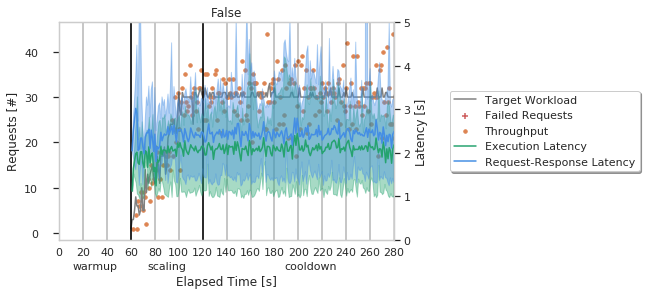

In [22]:
#preview 
provider = "ibm"
workload = "0,0,0.5"
fig,ax = plt.subplots()
plotClientSideOverview(ax,all,provider,workload,ylim=ylims[provider][workload],xlim=[0,280],with_thruput=True)


In [16]:
skip  = True
#experiment 1 graphs
ylims = {
        "aws":{"0,0,0.5":[0,3],"0,0,1":[0,3],"0,0,2":[0,3],"60,60,0.5":[0,3],"60,60,1":[0,3]},
        "ibm":{"0,0,0.5":[0,15],"0,0,1":[0,15],"0,0,2":[0,15],"60,60,0.5":[0,30],"60,60,1":[0,30]},
        "azure":{"0,0,0.5":[0,40],"0,0,1":[0,40],"0,0,2":[0,40],"60,60,0.5":[0,40],"60,60,1":[0,40]},
        "gcf":{"0,0,0.5":[0,30],"0,0,1":[0,30],"0,0,2":[0,30],"60,60,0.5":[0,30],"60,60,1":[0,30]}
}

def client_view_legend(ax):
    legendShapes = [
    Line2D([0], [0], color="gray", lw=2),
    Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
    Line2D([0], [0], color=style["Lats"]["RLat"], lw=2),
    Line2D([0], [0], color=style["Lats"]["ELat"], lw=2),
    ]
    legendNames = ["trps","RFailed","RLat","ELat",]
    ax2.legend(legendShapes, legendNames,loc="upper left",fancybox=True, shadow=True)


provider="azure"
if not skip: 
    for workload in configs:
        fig,ax = plt.subplots(figsize=(12,8))
        plt.suptitle("Client-View Impacts {} [{}]".format(style[provider]["name"],workload), fontsize=16,y=1.05)
        ax,ax2 = plotClientSideOverview(ax,all,provider,workload,
                    title="{}".format(style[provider]["name"]),legend=None,ylim=ylims[provider][workload])
        ax.set_xlim([0,280])


        client_view_legend(ax2)
        plt.suptitle("")
        ax.set_title("")
        plt.savefig("reports/CA-{}-{}.pdf".format(style[provider]["name"],workload), bbox_inches="tight")
        #plt.savefig("reports/ClientSideQA-{}-A.pdf".format(workload))
        #plt.close(fig)

In [17]:
#experiment 1 graphs
skip  = True
if not skip: 
    for workload in ["0,0,0.5","60,60,0.5"]:
        fig,axs = plt.subplots(2,figsize=(12,8))
        plt.suptitle("Client-Side Qualtites for [%s]"%workload, fontsize=16,y=1.05)
        idx = 0
        for provider in ["aws","ibm"]:
            ax = axs[idx]
            plotClientSideOverview(ax,all,provider,workload,
                    title="{}".format(style[provider]["name"]),legend=None,ylim=ylims[provider][workload])
            ax.set_xlim([0,280])
            idx+=1


        legendShapes = [
                Line2D([0], [0], color="gray", lw=2),
                Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                Line2D([0], [0], color=style["Lats"]["RLat"], lw=2),
                Line2D([0], [0], color=style["Lats"]["ELat"], lw=2)
            ]
        legendNames = ["Target Workload","Failed Requests",style["Names"]["RLat"],style["Names"]["ELat"]]
        axs[0].legend(legendShapes, legendNames,
            loc='upper center', bbox_to_anchor=(0.5, 1.25),fancybox=True, shadow=True, ncol=5)
    #plt.subplots_adjust(hspace=0.25)
        plt.tight_layout()
        plt.savefig("reports/ClientSideQA-{}-A.pdf".format(workload))
        plt.close(fig)

In [18]:
skip  = True
if not skip: 
    for workload in ["0,0,0.5","60,60,0.5"]:
        fig,axs = plt.subplots(2,figsize=(12,8))
        plt.suptitle("Client-Side Qualtites for [%s]"%workload, fontsize=16,y=1.05)
        idx = 0
        for provider in ["gcf","azure"]:
            ax = axs[idx]
            plotClientSideOverview(ax,all,provider,workload,
                    title="{}".format(style[provider]["name"]),legend=None,ylim=ylims[provider][workload])
            ax.set_xlim([0,280])
            idx+=1


        legendShapes = [
                Line2D([0], [0], color="gray", lw=2),
                Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                Line2D([0], [0], color=style["Lats"]["RLat"], lw=2),
                Line2D([0], [0], color=style["Lats"]["ELat"], lw=2)
            ]
        legendNames = ["Target Workload","Failed Requests",style["Names"]["RLat"],style["Names"]["ELat"]]
        axs[0].legend(legendShapes, legendNames,
            loc='upper center', bbox_to_anchor=(0.5, 1.25),fancybox=True, shadow=True, ncol=5)
    #plt.subplots_adjust(hspace=0.25)
        plt.tight_layout()
        plt.savefig("reports/ClientSideQA-{}-B.pdf".format(workload))
        plt.close(fig)

# Masterplot V2

In [19]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
all_280 = all[all["EStart"] < 280000]
#Latency Limits
ylims = {
        "aws":{"0,0,0.5":[0,3],"0,0,1":[0,3],"0,0,2":[0,3],"60,60,0.5":[0,3],"60,60,1":[0,3]},
        "ibm":{"0,0,0.5":[0,15],"0,0,1":[0,15],"0,0,2":[0,15],"60,60,0.5":[0,30],"60,60,1":[0,30]},
        "azure":{"0,0,0.5":[0,40],"0,0,1":[0,40],"0,0,2":[0,40],"60,60,0.5":[0,40],"60,60,1":[0,40]},
        "gcf":{"0,0,0.5":[0,30],"0,0,1":[0,30],"0,0,2":[0,30],"60,60,0.5":[0,30],"60,60,1":[0,30]}
}
#Heatmap obergrenze
vmax=12
#Heatmap VM-cutoff (VMs mit weniger als x [%] auslastung  ) Reduziert verticale dichte und rechenzeit
cutoff=0.1

### Vertical

In [20]:
skip = True
if not skip:
    with PdfPages("reports/overview_wide.pdf") as pdf:
        for workload in configs:
            for provider in providers:
                fig = plt.figure(figsize=(16,5))
                gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[5,3])
                plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
                ax = fig.add_subplot(gs[0, 0])
                plotClientSideOverview(ax,all_280,provider,workload,title="Client-side Impacts",legend=None,xlim=[0,280],ylim=ylims[provider][workload])
                legendShapes = [
                    Line2D([0], [0], color="gray", lw=2),
                    Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                    Line2D([0], [0], color=style["Lats"]["RLat"], lw=2),
                    Line2D([0], [0], color=style["Lats"]["ELat"], lw=2),
                    Line2D([0], [0], marker='|', lw=0,color='blue',markerfacecolor='blue', markersize=10)
                ]
                legendNames = ["Target Workload","Failed Requests",style["Names"]["RLat"],style["Names"]["ELat"],"First VM Occurrence"]
                ax.legend(legendShapes, legendNames,
                    loc='lower left', bbox_to_anchor=(0, -0.35),fancybox=True, shadow=True, ncol=12)
                ax = fig.add_subplot(gs[0, 1])
                plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                            legend=False,title="Provider-side Impacts",cmap=hmcmp,vmax=vmax)
                for _, spine in ax.spines.items():
                    spine.set_visible(True)
                #plt.tight_layout()
                pdf.savefig(fig, bbox_inches="tight")
                fig.savefig("reports/overview_wide_{}_{}.pdf"
                    .format(style[provider]["name"],workload)
                            , bbox_inches="tight"
                )

                plt.close(fig)

In [21]:
#masterplot wide with seperate legends
skip = True
if not skip:
    with PdfPages("reports/overview.pdf") as pdf:
        for workload in configs:
            for provider in providers:
                fig = plt.figure(figsize=(16,5))
                gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[5,3])
                plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
                ax = fig.add_subplot(gs[0, 0])
                plotClientSideOverview(ax,all_280,provider,workload,title="Client-side Impacts",
                                       legend=None,xlim=[0,280],ylim=ylims[provider][workload])
                legendShapes = [
                    Line2D([0], [0], color="gray", lw=2),
                    Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                    Line2D([0], [0], color=style["Lats"]["RLat"], lw=2),
                    Line2D([0], [0], color=style["Lats"]["ELat"], lw=2)

                ]
                legendNames = ["Target Workload","Failed Requests",style["Names"]["RLat"],style["Names"]["ELat"]]
                ax.legend(legendShapes, legendNames,
                    loc='lower center', bbox_to_anchor=(0.5, -0.4),fancybox=True, shadow=True, ncol=2)
                ax = fig.add_subplot(gs[0, 1])
                plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                            title="Provider-side Impacts",cmap=hmcmp,vmax=vmax)
                for _, spine in ax.spines.items():
                    spine.set_visible(True)
                #plt.tight_layout()
                pdf.savefig(fig, bbox_inches="tight")
                fig.savefig("reports/overview_{}_{}.pdf"
                    .format(style[provider]["name"],workload)
                            , bbox_inches="tight"
                )

                #plt.show()
                plt.close(fig)

### Horizental

In [22]:
skip = True
if not skip:
    with PdfPages("reports/overview_tall.pdf") as pdf:
        for workload in configs:
            for provider in providers:
                fig = plt.figure(figsize=(8,15))
                gs = fig.add_gridspec(ncols=1, nrows=2)
                plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
                ax = fig.add_subplot(gs[0, 0])
                plotClientSideOverview(ax,all_280,provider,workload,title="Client-side Impacts",
                                       legend=None,xlim=[0,280],ylim=ylims[provider][workload])
                legendShapes = [
                    Line2D([0], [0], color="gray", lw=2),
                    Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                    Line2D([0], [0], color=style["Lats"]["RLat"], lw=2),
                    Line2D([0], [0], color=style["Lats"]["ELat"], lw=2),
                    Line2D([0], [0], marker='|', lw=0,color='blue',markerfacecolor='blue', markersize=10)
                ]
                legendNames = ["Target Workload","Failed Requests",style["Names"]["RLat"],style["Names"]["ELat"],"First VM Occurrence"]
                ax.legend(legendShapes, legendNames,
                    loc='upper center', bbox_to_anchor=(0.5, 1.25),fancybox=True, shadow=True, ncol=2)
                ax.set_xlabel(None)
                ax = fig.add_subplot(gs[-1, 0])
                plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                            legend=False,title="Provider-side Impacts",cmap=hmcmp,vmax=vmax)
                for _, spine in ax.spines.items():
                    spine.set_visible(True)
                #plt.tight_layout()
                pdf.savefig(fig, bbox_inches="tight")
                fig.savefig("reports/overview_tall_{}_{}.pdf"
                    .format(style[provider]["name"],workload)
                            , bbox_inches="tight"
                )
                plt.show()
                plt.close(fig)

In [23]:
skip = True
if not skip:
    with PdfPages("reports/overview_tall_thr.pdf") as pdf:
        for workload in configs:
            for provider in providers:
                fig = plt.figure(figsize=(8,15))
                gs = fig.add_gridspec(ncols=1, nrows=2)
                plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
                ax = fig.add_subplot(gs[0, 0])
                plotClientSideOverview(ax,all_280,provider,workload,title="Client-side Impacts",
                                with_thruput=True,legend=None,xlim=[0,280],ylim=ylims[provider][workload])
                legendShapes = [
                    Line2D([0], [0], color="gray", lw=2),
                    Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                    Line2D([0], [0], color=style["Lats"]["RLat"], lw=2),
                    Line2D([0], [0], color=style["Lats"]["ELat"], lw=2),
                    Line2D([0], [0], marker='|', lw=0,color='blue',markerfacecolor='blue', markersize=10),
                    Line2D([0], [0], marker='o', lw=0,color=style[provider]["color"], markersize=5)
                ]
                legendNames = ["Target Workload",
                               "Failed Requests",
                               style["Names"]["RLat"],
                               style["Names"]["ELat"],
                               "First VM Occurrence",
                               "Throughput"
                            ]
                ax.legend(legendShapes, legendNames,
                    loc='upper center', bbox_to_anchor=(0.5, 1.25),fancybox=True, shadow=True, ncol=2)
                ax.set_xlabel(None)
                ax = fig.add_subplot(gs[-1, 0])
                plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],legend=False,
                            title="Provider-side Impacts",cmap=hmcmp,vmax=vmax)
                for _, spine in ax.spines.items():
                    spine.set_visible(True)
                #plt.tight_layout()
                pdf.savefig(fig, bbox_inches="tight")
                fig.savefig("reports/overview_tall_thr_{}_{}.pdf"
                    .format(style[provider]["name"],workload)
                            , bbox_inches="tight"
                )
                plt.close(fig)

In [24]:
def client_view_legend(ax):
    legendShapes = [
    Line2D([0], [0], color="gray", lw=2),
    Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
    Line2D([0], [0], color=style["Lats"]["RLat"], lw=2),
    Line2D([0], [0], color=style["Lats"]["ELat"], lw=2),
    ]
    legendNames = ["trps","RFailed","RLat","ELat",]
    ax2.legend(legendShapes, legendNames,loc="upper left",fancybox=True, shadow=True)

In [25]:
def provider_view_legend(ax):
    legendShapes = [
    Line2D([0], [0], marker='|', lw=0,color='blue',markerfacecolor='blue', markersize=10),
    Line2D([0], [0], lw=2,color=hmcmp[1], linestyle='-', marker='o',
                    markersize=15, markerfacecoloralt=hmcmp[-1],fillstyle="bottom")
    ]
    legendNames = [
               "HStart","HHeat"
              ]
    ax.legend(legendShapes, legendNames,loc="lower left",fancybox=True, shadow=True) 

## Paper Plots

In [26]:
skip = True
if not skip:  
    fig = plt.figure(figsize=(16,15))
    gs = fig.add_gridspec(ncols=2, nrows=2)
    #plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
    provider = "aws"
    workload="0,0,2"
    ax = fig.add_subplot(gs[0, 0])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL2 Client-View")
    ax = fig.add_subplot(gs[-1, 0])

    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("WL2 Platform-View".format(style[provider]["name"],workload))
    provider_view_legend(ax)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    workload="60,60,1"
    ax = fig.add_subplot(gs[0, 1])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL4 Client-View")
    ax = fig.add_subplot(gs[-1, 1])
    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("")
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.set_title("WL4 Platform-View")
    provider_view_legend(ax)
    plt.tight_layout()
    fig.savefig("reports/overview_tall_pair_{}_120.pdf"
        .format(style[provider]["name"])
                , bbox_inches="tight"
    )
    plt.show()
    plt.close(fig)
            

In [27]:
skip = True
if not skip:  
    fig = plt.figure(figsize=(16,15))
    gs = fig.add_gridspec(ncols=2, nrows=2)
    #plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
    provider = "ibm"
    workload="0,0,2"
    ax = fig.add_subplot(gs[0, 0])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL2 Client-View")
    ax = fig.add_subplot(gs[-1, 0])

    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("WL2 Platform-View".format(style[provider]["name"],workload))
    provider_view_legend(ax)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    workload="60,60,1"
    ax = fig.add_subplot(gs[0, 1])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL4 Client-View")
    ax = fig.add_subplot(gs[-1, 1])
    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("")
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.set_title("WL4 Platform-View")
    provider_view_legend(ax)
    plt.tight_layout()
    fig.savefig("reports/overview_tall_pair_{}_120.pdf"
        .format(style[provider]["name"])
                , bbox_inches="tight"
    )
    plt.show()
    plt.close(fig)
            

In [28]:
skip = True
if not skip:  
    fig = plt.figure(figsize=(16,15))
    gs = fig.add_gridspec(ncols=2, nrows=2)
    #plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
    provider = "gcf"
    workload="0,0,0.5"
    ax = fig.add_subplot(gs[0, 0])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL0 Client-View")
    ax = fig.add_subplot(gs[-1, 0])

    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("WL0 Platform-View".format(style[provider]["name"],workload))
    provider_view_legend(ax)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    workload="0,0,2"
    ax = fig.add_subplot(gs[0, 1])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL2 Client-View")
    ax = fig.add_subplot(gs[-1, 1])
    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("")
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.set_title("WL2 Platform-View")
    provider_view_legend(ax)
    plt.tight_layout()
    fig.savefig("reports/overview_tall_pair_{}_120.pdf"
        .format(style[provider]["name"])
                , bbox_inches="tight"
    )
    plt.show()
    plt.close(fig)
            

In [29]:
skip = True
if not skip:
    provider = "azure"
    workloads = ["0,0,0.5","0,0,1","60,60,0.5","60,60,1"]

    fig = plt.figure(figsize=(16,15))
    gs = fig.add_gridspec(ncols=2, nrows=2)
    ax = fig.add_subplot(gs[0, 0])

    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workloads[0],title=None,
                               legend=None,xlim=[0,280],ylim=ylims[provider][workloads[0]])
    client_view_legend(ax2)
    ax.set_title("WL0 Client-View")
    ax = fig.add_subplot(gs[0, 1])

    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workloads[1],title=None,
                               legend=None,xlim=[0,280],ylim=ylims[provider][workloads[1]])
    client_view_legend(ax2)
    ax.set_title("WL1 Client-View")
    ax = fig.add_subplot(gs[-1, 0])

    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workloads[2],title=None,
                               legend=None,xlim=[0,280],ylim=ylims[provider][workloads[2]])
    client_view_legend(ax2)
    ax.set_title("WL3 Client-View")
    ax = fig.add_subplot(gs[-1, -1])

    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workloads[3],title=None,
                               legend=None,xlim=[0,280],ylim=ylims[provider][workloads[3]])
    client_view_legend(ax2)
    ax.set_title("WL4 Client-View")

    plt.tight_layout()
    fig.savefig("reports/{}_overview.pdf"
            .format(style[provider]["name"])
                    , bbox_inches="tight"
    )

## Table

In [30]:
successfuls = all_280[all_280["RCode"] == 200]
successfuls["EStart_s"] = round(successfuls["EStart"]/1000)
successfuls["EEnd_s"] = round(successfuls["EEnd"]/1000)

workload = "0,0,1"
provider = "aws"

#successfuls[(successfuls["Provider"] == provider) & (successfuls["WL"] == workload)]["HId"].unique()

In [31]:
#format workload_i+provider_i*len(providers),second

foo = successfuls.groupby(["WL","Provider","RId"])

In [32]:
hids = np.zeros((len(configs)*len(providers),280))
requests = np.zeros((len(configs)*len(providers),280))

In [33]:
for wi in range(0,len(configs)):
    for pi in range(0,len(providers)):
        idx = wi+pi*len(providers)
        provider = providers[pi]
        workload = configs[wi]
        data = successfuls[(successfuls["Provider"] == provider) & (successfuls["WL"] == workload)]
        x = data.groupby(["WL","Provider","HId"])["EStart_s"].min().reset_index(name="first_start")
        x = x.groupby(["WL","Provider","first_start"])["HId"].count().cumsum().reset_index()
        for i in range(0,len(data)):
            for r in range(int(data.iloc[i]["EStart_s"]),int(data.iloc[i]["EEnd_s"])):
                if r < 280:
                    requests[idx,r] +=1
        for i in range(0,len(x)-1):
            a = x.iloc[i]
            b = x.iloc[i+1]
            for r in range(int(a["first_start"]),int(b["first_start"])):
                hids[idx,r] = a["HId"]

In [34]:
le_tabel = []
clms = []
for wi in range(0,len(configs)):
    for pi in range(0,len(providers)):
        idx = wi+pi*len(providers)
        provider = providers[pi]
        workload = configs[wi]
        clms.append("{} {}".format(provider,workload))
    

In [35]:
pd.DataFrame(hids,index=clms).to_csv("reports/hids.csv")
pd.DataFrame(requests,index=clms).to_csv("reports/requests.csv")

In [36]:

data = x[(x["Provider"] == provider) & (x["WL"] == workload)]
data

,WL,Provider,first_start,HId
0,"60,60,0.5",ibm,2.0,5
1,"60,60,0.5",ibm,3.0,9
2,"60,60,0.5",ibm,4.0,14
3,"60,60,0.5",ibm,5.0,20
4,"60,60,0.5",ibm,6.0,24
5,"60,60,0.5",ibm,7.0,29
6,"60,60,0.5",ibm,8.0,38
7,"60,60,0.5",ibm,9.0,47
8,"60,60,0.5",ibm,10.0,51
9,"60,60,0.5",ibm,11.0,54
